# Assignment5

In [59]:
import numpy as np
import scipy.io as sio
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


/home/zekaijin/Dropbox/McGIll 文件集/Spatiotemporal Data Mining/Assignment2/jupyter_env/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


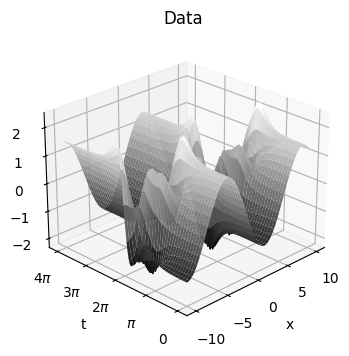

In [60]:
# Load data
F = sio.loadmat('spatiotemporal_data.mat')['f']      # (T × X)
data = F.T  

# space and time axis
x = np.linspace(-10, 10, F.shape[0])            
t = np.linspace(0.0, 4.0 * np.pi, F.shape[1])   # 0 → 4π
dt = t[1] - t[0]

Xm, Tm = np.meshgrid(x, t, indexing='ij')       # (space × time)

# 3D surface
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Xm, Tm, F,
                       cmap='gray', edgecolor='none', antialiased=True)

ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

# y axis：0, π, 2π, 3π, 4π
ax.set_yticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_yticklabels([r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])

ax.view_init(elev=25, azim=-135)

plt.show()


## Question1

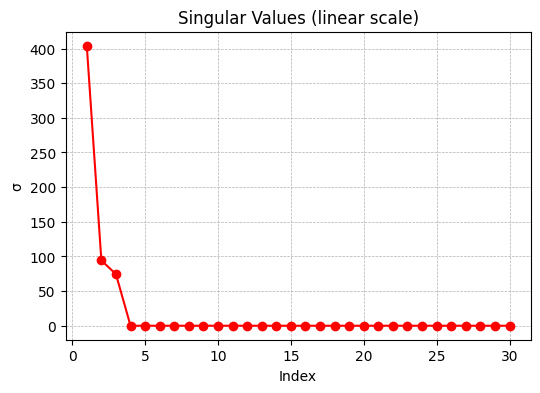

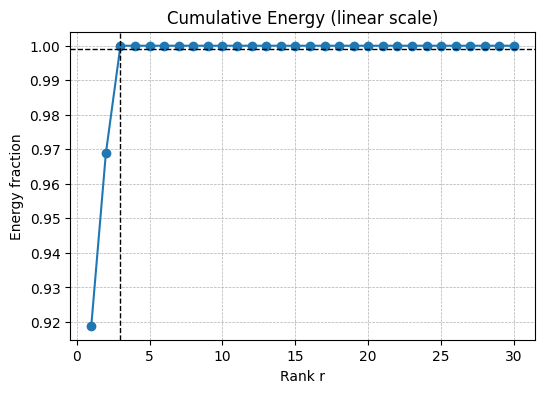

Effective rank by 99.9% cumulative energy: r = 3


In [62]:
# Build X, Y for DMD
X = data[:, :-1]
Y = data[:,  1:]

# SVD on X
U2, Sig2, Vh2 = la.svd(X, full_matrices=False)   # Sig2 is a 1D array of singular values

# Effective rank by 99.9% cumulative energy
energy = np.cumsum(Sig2**2) / np.sum(Sig2**2)
r_en = int(np.searchsorted(energy, 0.999) + 1)    # first r with ≥99.9%

# Linear-scale plots
k_show = min(30, len(Sig2))   # show first 30 for clarity

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, k_show+1), Sig2[:k_show], 'ro-')
plt.title("Singular Values (linear scale)")
plt.xlabel("Index")
plt.ylabel("σ")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, k_show+1), energy[:k_show], 'o-')
plt.axhline(0.999, color='k', linestyle='--', linewidth=1)
plt.axvline(r_en, color='k', linestyle='--', linewidth=1)
plt.title("Cumulative Energy (linear scale)")
plt.xlabel("Rank r")
plt.ylabel("Energy fraction")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print(f"Effective rank by 99.9% cumulative energy: r = {r_en}")


## Question2

In [63]:
#  X, Y, dt, U2, Sig2, Vh2, r_en
assert all(k in globals() for k in ["X","Y","dt","U2","Sig2","Vh2"])
if "r_en" not in globals():
    energy = np.cumsum(Sig2**2) / np.sum(Sig2**2)
    r_en = int(np.searchsorted(energy, 0.999) + 1)

U  = U2[:, :r_en]
Sig = np.diag(Sig2[:r_en])
V  = Vh2.conj().T[:, :r_en]

Atil = U.conj().T @ Y @ V @ np.linalg.inv(Sig)
mu, W = np.linalg.eig(Atil)   # discrete-time eigenvalues

In [64]:
Phi  = Y @ V @ np.linalg.inv(Sig) @ W
omega = np.log(mu) / dt       # continuous-time eigenvalues (rad / unit time)

In [65]:
# frequency = |Im(ω)| / (2π)  (cycles per unit time)
freq = np.abs(np.imag(omega)) / (2*np.pi)

# initial amplitudes
x0 = X[:, 0]
b  = np.linalg.lstsq(Phi, x0, rcond=None)[0]
order = np.argsort(-np.abs(b))

import pandas as pd
freq_df = pd.DataFrame({
    "mode": np.arange(1, len(mu)+1),
    "lambda (μ)": mu,
    "Re(ω)": np.real(omega),
    "Im(ω)": np.imag(omega),
    "frequency (cycles/unit)": freq,
    "|b|": np.abs(b)
}).iloc[order].reset_index(drop=True)

freq_df


,mode,lambda (μ),Re(ω),Im(ω),frequency (cycles/unit),|b|
0,1,0.998724+0.050497j,-2.488049e-14,1.604020,0.255288,28.464452
1,3,0.994243+0.107145j,2.949736e-15,3.408543,0.542486,7.293833
2,2,0.979653+0.200700j,9.370723e-15,6.416080,1.021151,6.316642


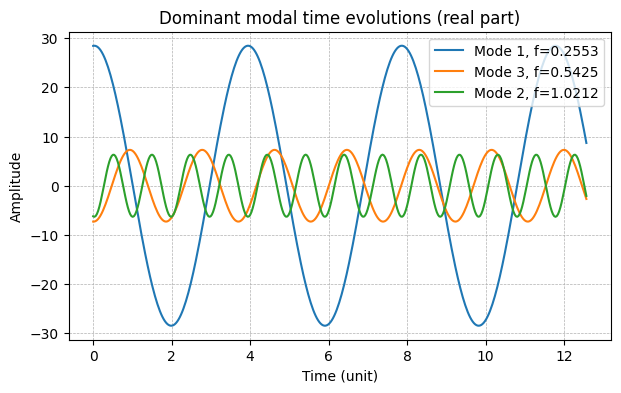

In [66]:
k = min(3, len(mu))
tt = t   
plt.figure(figsize=(7,4))
for i in range(k):
    idx = order[i]
    y = np.real(np.exp(omega[idx]*tt) * b[idx])
    plt.plot(tt, y, label=f"Mode {idx+1}, f={freq[idx]:.4f}")
plt.title("Dominant modal time evolutions (real part)")
plt.xlabel("Time (unit)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


## Question3

In [71]:
def reconstruct_dmd(Phi, omega, b, times):
    Vand = np.exp(np.outer(omega, times))   # (modes × T_used)
    return Phi @ (b[:, None] * Vand)        # (space × T_used)

# X = data[:, :-1]，column number is len(t)-1
# Ensure t_used length matches X.shape[1] for proper reconstruction
t_used = t[:X.shape[1]] if X.shape[1] < len(t) else t

Xrec_used = reconstruct_dmd(Phi, omega, b, t_used)
assert Xrec_used.shape == X[:, :Xrec_used.shape[1]].shape

# compare with the corresponding length of X (when t_used=t[:-1], the two shapes match exactly)
X_obs = X[:, :Xrec_used.shape[1]]
rel_err = la.norm(np.real(X_obs) - np.real(Xrec_used), 'fro') / la.norm(np.real(X_obs), 'fro')
print(f"[Q3] Relative reconstruction error (real parts) on observed window = {rel_err:.3e}")


[Q3] Relative reconstruction error (real parts) on observed window = 9.304e-14


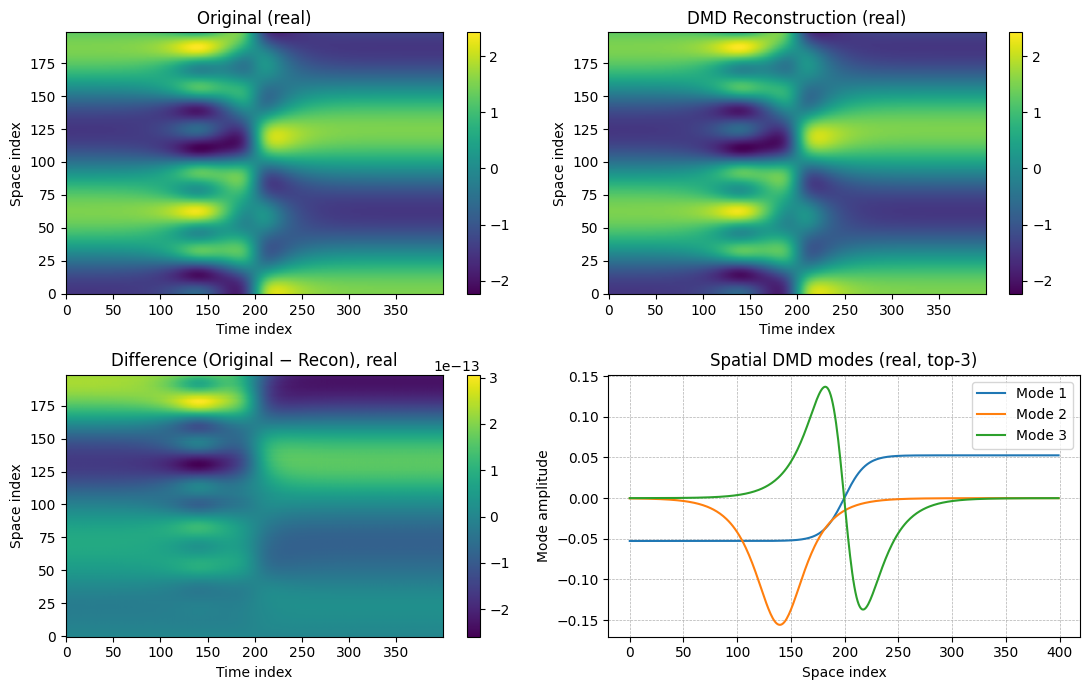

In [72]:
# Dependent on X, t, Phi, omega, b; if X = data[:,:-1], it will automatically be aligned with t[:-1].
def reconstruct_dmd(Phi, omega, b, times):
    Vand = np.exp(np.outer(omega, times))   # (modes × T_used)
    return Phi @ (b[:, None] * Vand)        # (space × T_used)

# Time axis aligned with X column number
t_used = t if X.shape[1] == len(t) else t[:X.shape[1]]

# reconstruct
Xrec_used = reconstruct_dmd(Phi, omega, b, t_used)

# 2×2 diagonal figure
fig, axes = plt.subplots(2, 2, figsize=(11, 7))

# (1) original 
im0 = axes[0,0].imshow(np.real(X[:, :Xrec_used.shape[1]]).T, aspect='auto', origin='lower')
axes[0,0].set_title("Original (real)"); axes[0,0].set_xlabel("Time index"); axes[0,0].set_ylabel("Space index")
fig.colorbar(im0, ax=axes[0,0])

# (2) reconstruction
im1 = axes[0,1].imshow(np.real(Xrec_used).T, aspect='auto', origin='lower')
axes[0,1].set_title("DMD Reconstruction (real)"); axes[0,1].set_xlabel("Time index"); axes[0,1].set_ylabel("Space index")
fig.colorbar(im1, ax=axes[0,1])

# (3) difference
diff = np.real(X[:, :Xrec_used.shape[1]] - Xrec_used)
im2 = axes[1,0].imshow(diff.T, aspect='auto', origin='lower')
axes[1,0].set_title("Difference (Original − Recon), real"); axes[1,0].set_xlabel("Time index"); axes[1,0].set_ylabel("Space index")
fig.colorbar(im2, ax=axes[1,0])

# (4) superposition of first three spatial modes (real part)
mplot = min(3, Phi.shape[1])
for i in range(mplot):
    axes[1,1].plot(np.real(Phi[:, i]), label=f"Mode {i+1}")
axes[1,1].set_title("Spatial DMD modes (real, top-3)")
axes[1,1].set_xlabel("Space index"); axes[1,1].set_ylabel("Mode amplitude")
axes[1,1].grid(True, linestyle='--', linewidth=0.5); axes[1,1].legend()

plt.tight_layout(); plt.show()


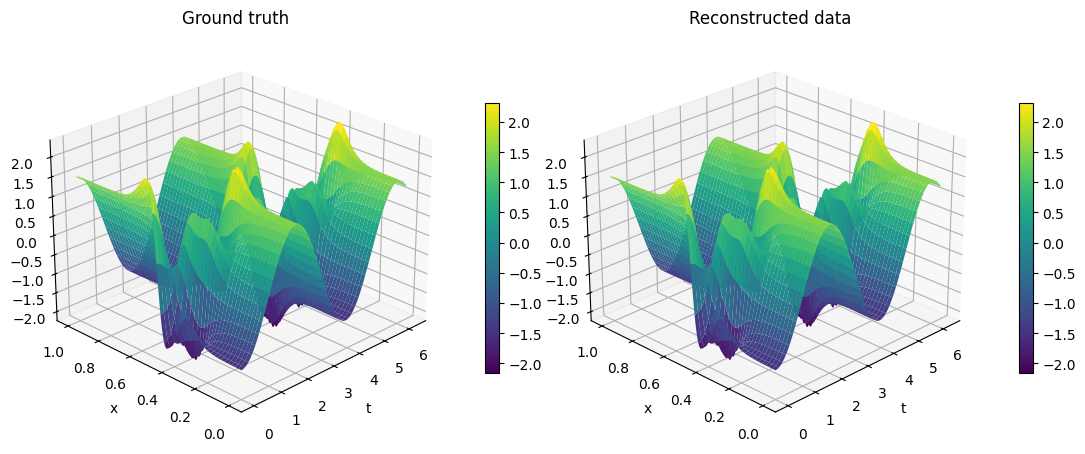

In [73]:
def reconstruct_dmd(Phi, omega, b, times):
    Vand = np.exp(np.outer(omega, times))          # (modes × T_used)
    return Phi @ (b[:, None] * Vand)               # (space × T_used)

t_used = t if X.shape[1] == len(t) else t[:X.shape[1]]

# reconstruct 
Xrec_used = reconstruct_dmd(Phi, omega, b, t_used)    # (space × T_used)
Z_true = np.real(X[:, :Xrec_used.shape[1]])
Z_reco = np.real(Xrec_used)

x_safe = globals().get('x', None)
if x_safe is None or not hasattr(x_safe, "__len__") or len(x_safe) != Z_true.shape[0]:
    x = np.linspace(0.0, 1.0, Z_true.shape[0])        # fallback
else:
    x = np.asarray(x_safe)

# meshgrid
Xm, Tm = np.meshgrid(x, t_used, indexing='ij')

# sync z-limits for fair comparison
zmin = min(Z_true.min(), Z_reco.min())
zmax = max(Z_true.max(), Z_reco.max())

fig, (axL, axR) = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(11, 4.8))

surfL = axL.plot_surface(Tm, Xm, Z_true, cmap='viridis', linewidth=0, antialiased=True)
axL.set_title('Ground truth'); axL.set_xlabel('t'); axL.set_ylabel('x')
axL.set_zlim(zmin, zmax); axL.view_init(elev=25, azim=-135)
fig.colorbar(surfL, ax=axL, shrink=0.6, pad=0.08)

surfR = axR.plot_surface(Tm, Xm, Z_reco, cmap='viridis', linewidth=0, antialiased=True)
axR.set_title('Reconstructed data'); axR.set_xlabel('t'); axR.set_ylabel('x')
axR.set_zlim(zmin, zmax); axR.view_init(elev=25, azim=-135)
fig.colorbar(surfR, ax=axR, shrink=0.6, pad=0.08)

plt.tight_layout()
# plt.savefig("q3_3d_side_by_side.png", dpi=300, bbox_inches="tight")
plt.show()


## Question4


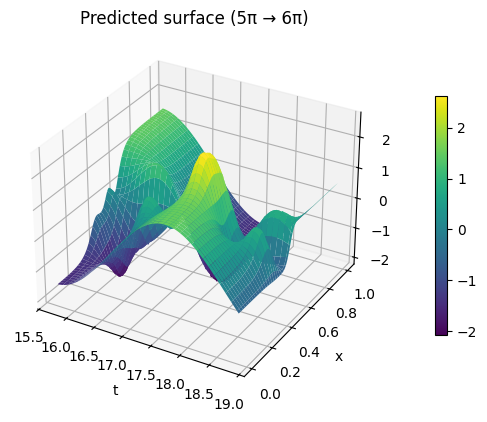

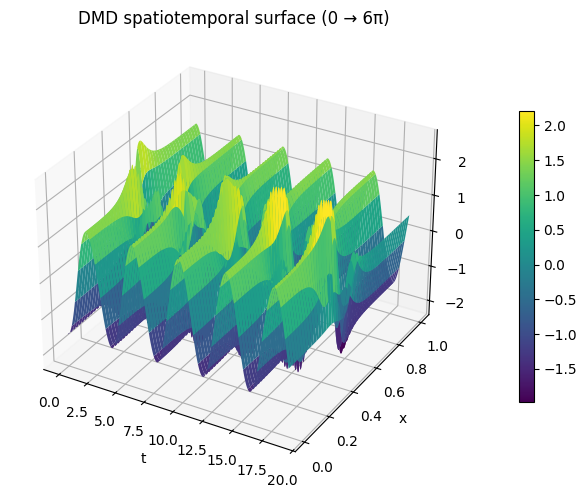

In [ ]:
def reconstruct_dmd(Phi, omega, b, times):
    Vand = np.exp(np.outer(omega, times))            # (modes × len(times))
    return Phi @ (b[:, None] * Vand)                 # (space × len(times))

# 5π → 6π prediction-only
t_end_obs = t[-1]  # Use actual end time of observed data (4π)
t_pred_start = 5.0 * pi  # Prediction starts at 5π
t_pred_end = 6.0 * pi    # Prediction ends at 6π
# Calculate number of time steps needed to cover 5π to 6π
n_future = int(np.round((t_pred_end - t_pred_start) / dt))  # Number of intervals
# Generate time points from 5π to 6π (inclusive of both endpoints)
t_future = t_pred_start + np.arange(0, n_future + 1) * dt  # Start from 5π, end at 6π
X_future = reconstruct_dmd(Phi, omega, b, t_future)  # (space × T_future)

# space axis for plotting
x_safe = globals().get('x', None)
if x_safe is None or len(np.atleast_1d(x_safe)) != X_future.shape[0]:
    x = np.linspace(-10.0, 10.0, X_future.shape[0])
else:
    x = np.asarray(x_safe)

Xm_f, Tm_f = np.meshgrid(x, t_future, indexing='ij')
Zpred = np.real(X_future)

fig1 = plt.figure(figsize=(7.5, 4.2))
ax1 = fig1.add_subplot(111, projection="3d")
surf1 = ax1.plot_surface(Tm_f, Xm_f, Zpred, cmap="viridis", linewidth=0, antialiased=True)
ax1.set_title("Predicted surface (5π → 6π)")
ax1.set_xlabel("t"); ax1.set_ylabel("x")
fig1.colorbar(surf1, ax=ax1, shrink=0.65, pad=0.08)
plt.tight_layout()
plt.show()

# use DMD to predict future
t_all = np.arange(0.0, 6.0*np.pi, dt)  
X_all = reconstruct_dmd(Phi, omega, b, t_all)

# space axis
x_safe = globals().get('x', None)
if x_safe is None or len(np.atleast_1d(x_safe)) != X_all.shape[0]:
    x = np.linspace(-10.0, 10.0, X_all.shape[0])
else:
    x = np.asarray(x_safe)

Xm_all, Tm_all = np.meshgrid(x, t_all)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Tm_all, Xm_all, np.real(X_all).T,
                       cmap='viridis', linewidth=0, antialiased=True)
ax.set_title("DMD spatiotemporal surface (0 → 6π)")
ax.set_xlabel("t"); ax.set_ylabel("x")
fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.08)

plt.tight_layout()
plt.show()
